In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import hvplot.pandas
import geopandas as gpd
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Import API key
from api_keys import geoapify_key

In [2]:
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System (3).csv')
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv')
COW_Country_Codes = pd.read_csv('Resources/COW-country-codes.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')

In [3]:
COW_Country_Codes.head()

,StateAbb,CCode,StateNme
0,USA,2,United States of America
1,CAN,20,Canada
2,BHM,31,Bahamas
3,CUB,40,Cuba
4,HAI,41,Haiti


In [4]:
COW_Country_Codes['StateNme'] = COW_Country_Codes['StateNme'].str.strip().str.lower()
aqua_csv['Area'] = aqua_csv['Area'].str.strip().str.lower()

In [5]:
code_to_country = pd.Series(COW_Country_Codes.StateNme.values, index=COW_Country_Codes.CCode).to_dict()
print(len(code_to_country))

217


In [6]:
mie_csv['ccode1'] = mie_csv['ccode1'].map(code_to_country)
mie_csv['ccode2'] = mie_csv['ccode2'].map(code_to_country)
mie_csv.head()

,micnum,eventnum,ccode1,ccode2,stmon,stday,styear,endmon,endday,endyear,sidea1,action,hostlev,fatalmin1,fatalmax1,fatalmin2,fatalmax2,version
0,2,1,united states of america,united kingdom,5,-9,1902,5,-9,1902,1,7,3,0,0,0,0,mie-1.0
1,3,1,austria-hungary,yugoslavia,10,7,1913,10,7,1913,1,1,2,0,0,0,0,mie-1.0
2,4,2,albania,united kingdom,5,15,1946,5,15,1946,1,16,4,0,0,0,0,mie-1.0
3,4,3,united kingdom,albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0
4,4,4,united kingdom,albania,10,22,1946,10,22,1946,0,7,3,0,0,0,0,mie-1.0


In [7]:
mie_csv = mie_csv.rename(columns={'ccode1': 'Country'})
mie_csv = mie_csv.rename(columns={'ccode2': 'Target Country'})
aqua_csv = aqua_csv.rename(columns={'Area': 'Country'})
COW_Country_Codes = COW_Country_Codes.rename(columns={'StateNme':'Country'})
mie_csv = mie_csv.rename(columns={'styear': 'Year'})


In [8]:
# get the total fatalities for each country for all years combined
average_water_stress = aqua_csv.groupby(['Country'])['Value'].mean().reindex()
average_water_stress

Country
afghanistan             57.827629
albania                  8.016851
algeria                 76.233090
angola                   1.666540
antigua and barbuda      7.392308
                          ...    
viet nam                14.220221
world                   17.883333
yemen                  160.491429
zambia                   2.908628
zimbabwe                29.135411
Name: Value, Length: 184, dtype: float64

In [10]:
# Filter the DataFrame for the desired year range
filtered_mie_csv = mie_csv[(mie_csv['Year'] >= 1980) & (mie_csv['Year'] <= 2014)]


# Group by 'Country' and 'Year', and sum 'fatalmax2'
total_fatal_max = filtered_mie_csv.groupby(['Target Country'])['fatalmax2'].sum().reset_index()
total_fatal = total_fatal_max[(total_fatal_max['fatalmax2'] > 0) & (total_fatal_max['fatalmax2'] < 30000)]
total_fatal

,Target Country,fatalmax2
0,afghanistan,6584
1,albania,3
3,angola,1025
5,argentina,403
6,armenia,6
...,...,...
156,yemen arab republic,6
157,yemen people's republic,25
158,yugoslavia,1578
159,zambia,1


In [11]:
fatal_water_stress = pd.merge(average_water_stress, total_fatal, left_on='Country', right_on='Target Country', how='inner')
fatal_water_stress

,Value,Target Country,fatalmax2
0,57.827629,afghanistan,6584
1,8.016851,albania,3
2,1.666540,angola,1025
3,8.643225,argentina,403
4,49.401214,armenia,6
5,7.539221,australia,1
6,53.447253,azerbaijan,4978
7,5.723339,bangladesh,122
8,2.652811,bosnia and herzegovina,1160
9,1.036545,cambodia,28


In [13]:
# Define the bins and labels for the categories
bins = [0, 25, 50, 75, 100, float('inf')]
labels = ['No Stress', 'Low Stress', 'Medium Stress', 'High Stress', 'Critical Stress']

# Create a new column 'Stress_Category' using pd.cut()
fatal_water_stress['Stress_Category'] = pd.cut(fatal_water_stress['Value'], 
                                                  bins=bins, 
                                                  labels=labels, 
                                                  include_lowest=True)

# Display the result
print(fatal_water_stress[['Target Country', 'Value', 'Stress_Category', 'fatalmax2']].head(10))

           Target Country      Value Stress_Category  fatalmax2
0             afghanistan  57.827629   Medium Stress       6584
1                 albania   8.016851       No Stress          3
2                  angola   1.666540       No Stress       1025
3               argentina   8.643225       No Stress        403
4                 armenia  49.401214      Low Stress          6
5               australia   7.539221       No Stress          1
6              azerbaijan  53.447253   Medium Stress       4978
7              bangladesh   5.723339       No Stress        122
8  bosnia and herzegovina   2.652811       No Stress       1160
9                cambodia   1.036545       No Stress         28


In [14]:
stats.ttest_ind(fatal_water_stress['Value'], fatal_water_stress['fatalmax2'], equal_var=False)

TtestResult(statistic=-2.5952108397521636, pvalue=0.011679275575299745, df=64.82713307913194)

In [15]:
# Perform one-way ANOVA
model = ols('fatalmax2 ~ C(Stress_Category)', data=fatal_water_stress).fit()
anova_table = anova_lm(model, typ=2)

print(anova_table)

                          sum_sq    df         F   PR(>F)
C(Stress_Category)  4.005420e+07   4.0  6.439935  0.00026
Residual            8.396539e+07  54.0       NaN      NaN


            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1         group2     meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------------
Critical Stress   High Stress    -1096.5 0.7825 -3801.5975  1608.5975  False
Critical Stress    Low Stress  -558.5556 0.8557 -2140.2405  1023.1294  False
Critical Stress Medium Stress  2784.6667 0.0099   492.5874  5076.7459   True
Critical Stress     No Stress  -853.1176 0.2932 -2073.7729   367.5376  False
    High Stress    Low Stress   537.9444 0.9813 -2213.0054  3288.8943  False
    High Stress Medium Stress  3881.1667 0.0104   668.7493   7093.584   True
    High Stress     No Stress   243.3824 0.9988 -2317.0858  2803.8505  False
     Low Stress Medium Stress  3343.2222 0.0016   997.2043  5689.2401   True
     Low Stress     No Stress  -294.5621 0.9695 -1613.7179  1024.5937  False
  Medium Stress     No Stress -3637.7843 0.0001 -5757.2352 -1518.3334   True

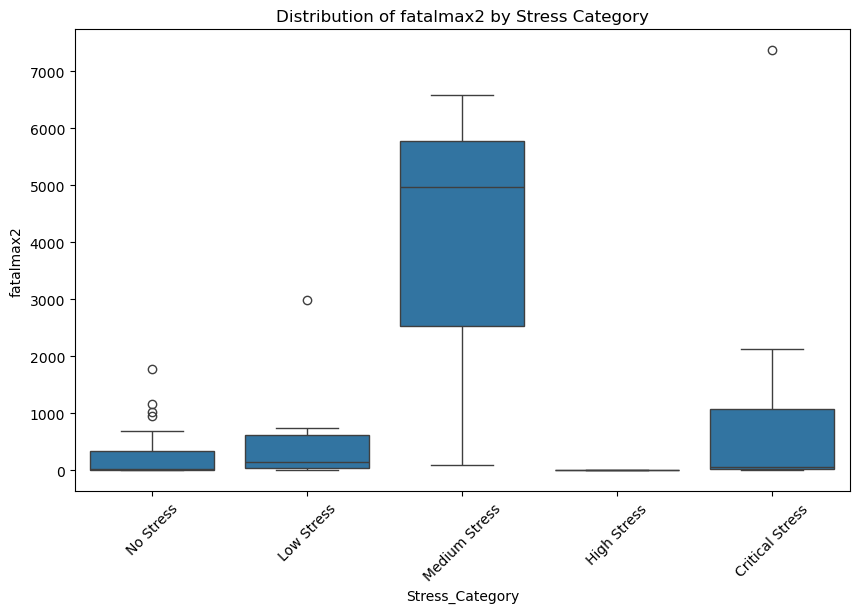

In [16]:
# If you want to perform a post-hoc test (e.g., Tukey's HSD)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_results = pairwise_tukeyhsd(fatal_water_stress['fatalmax2'], fatal_water_stress['Stress_Category'])
print(tukey_results)

# Optionally, you can visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Stress_Category', y='fatalmax2', data=fatal_water_stress)
plt.title('Distribution of fatalmax2 by Stress Category')
plt.ylabel('fatalmax2')
plt.xticks(rotation=45)
plt.show()

In [17]:
fatal_stress_max = pd.merge(average_water_stress, total_fatal_max, left_on='Country', right_on='Target Country', how='inner')
fatal_stress_max

,Value,Target Country,fatalmax2
0,57.827629,afghanistan,6584
1,8.016851,albania,3
2,76.233090,algeria,0
3,1.666540,angola,1025
4,8.643225,argentina,403
...,...,...,...
124,29.739982,united states of america,44
125,147.648818,uzbekistan,5
126,160.491429,yemen,50
127,2.908628,zambia,1


In [18]:
# Create a new column 'Stress_Category' using pd.cut()
fatal_stress_max['Stress_Category'] = pd.cut(fatal_stress_max['Value'], 
                                                  bins=bins, 
                                                  labels=labels, 
                                                  include_lowest=True)

# Display the result
print(fatal_stress_max[['Target Country', 'Value', 'Stress_Category', 'fatalmax2']].head(10))

  Target Country       Value  Stress_Category  fatalmax2
0    afghanistan   57.827629    Medium Stress       6584
1        albania    8.016851        No Stress          3
2        algeria   76.233090      High Stress          0
3         angola    1.666540        No Stress       1025
4      argentina    8.643225        No Stress        403
5        armenia   49.401214       Low Stress          6
6      australia    7.539221        No Stress          1
7        austria    9.820638        No Stress          0
8     azerbaijan   53.447253    Medium Stress       4978
9        bahrain  195.257692  Critical Stress          0


In [19]:
stats.ttest_ind(fatal_stress_max['Value'], fatal_stress_max['fatalmax2'], equal_var=False)

TtestResult(statistic=-1.2172463525855455, pvalue=0.22574949664968832, df=128.02466050944815)

In [20]:
# Perform one-way ANOVA
model = ols('fatalmax2 ~ C(Stress_Category)', data=fatal_stress_max).fit()
anova_table = anova_lm(model, typ=2)

print(anova_table)

                          sum_sq     df         F    PR(>F)
C(Stress_Category)  7.704391e+09    4.0  3.296728  0.013224
Residual            7.244642e+10  124.0       NaN       NaN


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1         group2      meandiff  p-adj     lower      upper    reject
------------------------------------------------------------------------------
Critical Stress   High Stress   -929.6026    1.0 -33954.7403 32095.5352  False
Critical Stress    Low Stress   -626.2067    1.0  -25611.386 24358.9725  False
Critical Stress Medium Stress  28470.7308  0.046    325.3337 56616.1279   True
Critical Stress     No Stress   -409.6978    1.0 -20352.6609 19533.2653  False
    High Stress    Low Stress    303.3958    1.0 -31729.1062 32335.8979  False
    High Stress Medium Stress  29400.3333 0.1348  -5153.7602 63954.4269  False
    High Stress     No Stress    519.9048    1.0 -27756.3005   28796.11  False
     Low Stress Medium Stress  29096.9375 0.0276   2123.1569 56070.7181   True
     Low Stress     No Stress    216.5089    1.0 -18035.7031 18468.7209  False
  Medium Stress     No Stress -28880.4286 0.0045 -51

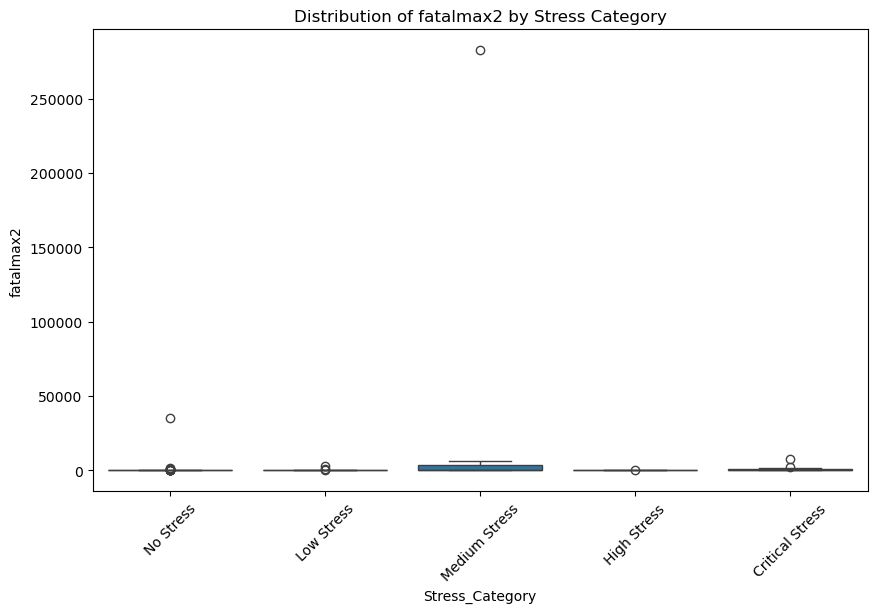

In [21]:
# Perform Tukey HSD test
tukey_results = pairwise_tukeyhsd(fatal_stress_max['fatalmax2'], fatal_stress_max['Stress_Category'])
print(tukey_results)

# Optionally, you can visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Stress_Category', y='fatalmax2', data=fatal_stress_max)
plt.title('Distribution of fatalmax2 by Stress Category')
plt.ylabel('fatalmax2')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Base URL for the Geoapify Geocoding API
base_url = "https://api.geoapify.com/v1/geocode/search"

# Create dictionaries to store the results of the API requests
cache = {}

# Iterate over the DataFrame
for index, row in fatal_stress_max.iterrows():
    # Extract country names
    target_country = row['Target Country']

    # Function to get latitude and longitude from Geoapify
    def get_coordinates(country_name):
        # Check if the result is already in the cache
        if country_name in cache:
            return cache[country_name]
        
        # Set parameters for the API request
        params = {
            'text': country_name,
            'apiKey': geoapify_key,
        }
        
        # Make the API request
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # Extract latitude and longitude from the response
        try:
            lat = data['features'][0]['properties']['lat']
            lng = data['features'][0]['properties']['lon']
            # Cache the result
            cache[country_name] = (lat, lng)
            return lat, lng
        except (KeyError, IndexError):
            # Handle cases where the API doesn't return a valid result
            print(f"Could not find coordinates for {country_name}")
            return None, None

    # Get coordinates for 'Target Country'
    lat_targ, lng_targ = get_coordinates(target_country)
    fatal_stress_max.at[index, 'Targ_Country_Lat'] = lat_targ
    fatal_stress_max.at[index, 'Targ_Country_Lng'] = lng_targ

# Display the updated DataFrame
fatal_stress_max.head()

,Value,Target Country,fatalmax2,Stress_Category,Targ_Country_Lat,Targ_Country_Lng
0,57.827629,afghanistan,6584,Medium Stress,33.768006,66.238514
1,8.016851,albania,3,No Stress,41.000028,19.999962
2,76.233090,algeria,0,High Stress,28.000027,2.999983
3,1.666540,angola,1025,No Stress,-11.877577,17.569124
4,8.643225,argentina,403,No Stress,-34.996496,-64.967282


In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

# Create copies of the DataFrames
world_normalized = world.copy()
world_normalized.rename(columns={'name': 'Country'}, inplace=True)

# Normalize case and strip whitespace for merging
world_normalized['Country'] = world_normalized['Country'].str.strip().str.lower()

# Replace problematic country names in both columns
fatal_stress_max['Target Country'] = fatal_stress_max['Target Country'].replace('democratic republic of the congo', 'congo')
world_normalized['Country'] = world_normalized['Country'].replace("cÃ´te d'ivoire", "co´te d'Ivoire")
world_normalized['Country'] = world_normalized['Country'].replace('dem. rep. congo', 'congo')

# Merge on 'Country'
geo_merged = world_normalized.merge(
    fatal_stress_max,
    left_on='Country',
    right_on='Target Country',
    how='inner'
)

# Display the merged DataFrame
print(len(geo_merged))
geo_merged.head()

C:\Users\Owner\AppData\Local\Temp\ipykernel_23544\258886928.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


126


,pop_est,continent,Country,iso_a3,gdp_md_est,geometry,Value,Target Country,fatalmax2,Stress_Category,Targ_Country_Lat,Targ_Country_Lng
0,37589262.0,North America,canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",4.259828,canada,0,No Stress,61.066692,-107.991707
1,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",29.739982,united states of america,44,Low Stress,39.783730,-100.445882
2,18513930.0,Asia,kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",33.743223,kazakhstan,0,Low Stress,48.101295,66.778082
3,33580650.0,Asia,uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",147.648818,uzbekistan,5,Critical Stress,41.323730,63.952810
4,8776109.0,Oceania,papua new guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",0.124101,papua new guinea,0,No Stress,-5.681607,144.248908


In [24]:
# Perform log transformations on the 'Value', 'gdp_md_est', and 'fatalmax2' columns
geo_merged['Log_Value'] = np.log1p(geo_merged['Value'])  
geo_merged['Log_gdp'] = np.log1p(geo_merged['gdp_md_est'])  
geo_merged['Log_fatal'] = np.log1p(geo_merged['fatalmax2'])
print(len(geo_merged))
geo_merged.head()

126


,pop_est,continent,Country,iso_a3,gdp_md_est,geometry,Value,Target Country,fatalmax2,Stress_Category,Targ_Country_Lat,Targ_Country_Lng,Log_Value,Log_gdp,Log_fatal
0,37589262.0,North America,canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",4.259828,canada,0,No Stress,61.066692,-107.991707,1.660098,14.367340,0.000000
1,328239523.0,North America,united states of america,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",29.739982,united states of america,44,Low Stress,39.783730,-100.445882,3.425564,16.880453,3.806662
2,18513930.0,Asia,kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",33.743223,kazakhstan,0,Low Stress,48.101295,66.778082,3.547985,12.109925,0.000000
3,33580650.0,Asia,uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",147.648818,uzbekistan,5,Critical Stress,41.323730,63.952810,5.001587,10.966853,1.791759
4,8776109.0,Oceania,papua new guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",0.124101,papua new guinea,0,No Stress,-5.681607,144.248908,0.116984,10.119808,0.000000


In [26]:
# Create a choropleth map
choropleth_map = geo_merged.hvplot.polygons(
    geo=True,  # Enable geographic plotting
    tiles='OSM',  # Add a tile layer for context
    c='Log_Value',  # Column to color by
    cmap='OrRd',  # Choose a color map
    line_width=0.5,
    line_color='black',
    width=1920,
    height=1080,
    title='Water Stress by Country',
    #hover_cols=['Country', 'Value', 'fatalmax2'],
)
choropleth_map

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (Log_Value)

In [27]:
# Create a points layer using hvplot
points_layer = geo_merged.hvplot.points(
    x = 'Targ_Country_Lng',
    y = 'Targ_Country_Lat',
    geo = True,
    tiles='OSM',  # Add a tile layer for context
    s ='fatalmax2',  # Size based on Event Count
    color= 'Target Country',  # Color of the points
    alpha=0.5,  # Transparency
    width=1920,
    height=1080,
    hover_cols=['Target Country'],  # Columns to display on hover
    legend=False  # Disable legend for points
)

# Display map
points_layer

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Target Country,fatalmax2)

In [28]:
combined_map = choropleth_map * points_layer
combined_map = combined_map.opts(title='Water Stress and Conflict Fatalities by Country (1980-2014)')
combined_map

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (Log_Value)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Target Country,fatalmax2)

In [29]:
# Create a choropleth map
choropleth_map2 = world_normalized.hvplot.polygons(
    geo=True,  # Enable geographic plotting
    tiles='OSM',  # Add a tile layer for context
    c='pop_est',  # Column to color by
    cmap='YlGnBu',  # Choose a color map
    line_width=0.5,
    line_color='black',
    width=1920,
    height=1080,
    title='Estimated Population by Country',
    #hover_cols=['Country', 'Value', 'fatalmax2'],
)
choropleth_map2

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (pop_est)

In [30]:
combined_map2 = choropleth_map2 * points_layer
combined_map2 = combined_map2.opts(title='Estimated Population and Conflict Fatalities by Country')
combined_map2

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (pop_est)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Target Country,fatalmax2)

In [31]:
# Create a points layer using hvplot
points_layer2 = geo_merged.hvplot.points(
    x = 'Targ_Country_Lng',
    y = 'Targ_Country_Lat',
    geo = True,
    tiles='OSM',  # Add a tile layer for context
    s ='Value',  # Size based on Event Count
    color= 'Red',  # Color of the points
    alpha=0.5,  # Transparency
    width=1920,
    height=1080,
    #hover_cols=['Conflict'],  # Columns to display on hover
    legend=False  # Disable legend for points
)

# Display map

points_layer2

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Value)

In [32]:
combined_map3 = choropleth_map2 * points_layer2
combined_map3 = combined_map3.opts(title='Estimated Population and Water Stress by Country')
combined_map3

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (pop_est)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Value)

In [33]:
# Create a choropleth map
choropleth_map3 = world_normalized.hvplot.polygons(
    geo=True,  # Enable geographic plotting
    tiles='OSM',  # Add a tile layer for context
    c='gdp_md_est',  # Column to color by
    cmap='YlGn',  # Choose a color map
    line_width=0.5,
    line_color='black',
    width=1920,
    height=1080,
    title='Gross Domestic Product by Country',
    #hover_cols=['Country', 'Value', 'fatalmax2'],
)
choropleth_map3

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (gdp_md_est)

In [34]:
combined_map4 = choropleth_map3 * points_layer2
combined_map4 = combined_map4.opts(title='Gross Domestic Product and Water Stress by Country')
combined_map4

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (gdp_md_est)
   .WMTS.II    :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Targ_Country_Lng,Targ_Country_Lat]   (Value)